## 0 - Librairies

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import label_binarize
import seaborn as sns
from tensorflow.keras import optimizers
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.layers import BatchNormalization, RandomRotation, RandomTranslation, RandomZoom, RandomBrightness
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.config import run_functions_eagerly

In [58]:
run_functions_eagerly((True))

## 1 - Data Preparation

In [59]:
X_train = np.load("Images/train_images.npy") 
y_train = np.load("Images/train_labels.npy") 
X_test = np.load("Images/test_images.npy")  
y_test = np.load("Images/test_labels.npy")  

In [60]:
print(f'Shape of data X_train:{X_train.shape}\n')
print(f'Shape of data y_train:{y_train.shape}\n')
print(f'Shape of data X_test:{X_test.shape}\n')
print(f'Shape of data y_test:{y_test.shape}')

Shape of data X_train:(60000, 28, 28, 1)

Shape of data y_train:(60000,)

Shape of data X_test:(10000, 28, 28, 1)

Shape of data y_test:(10000,)


In [61]:
# Normalize images
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [62]:
# Reshape images for CNN model
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

## 2 - Data Viz

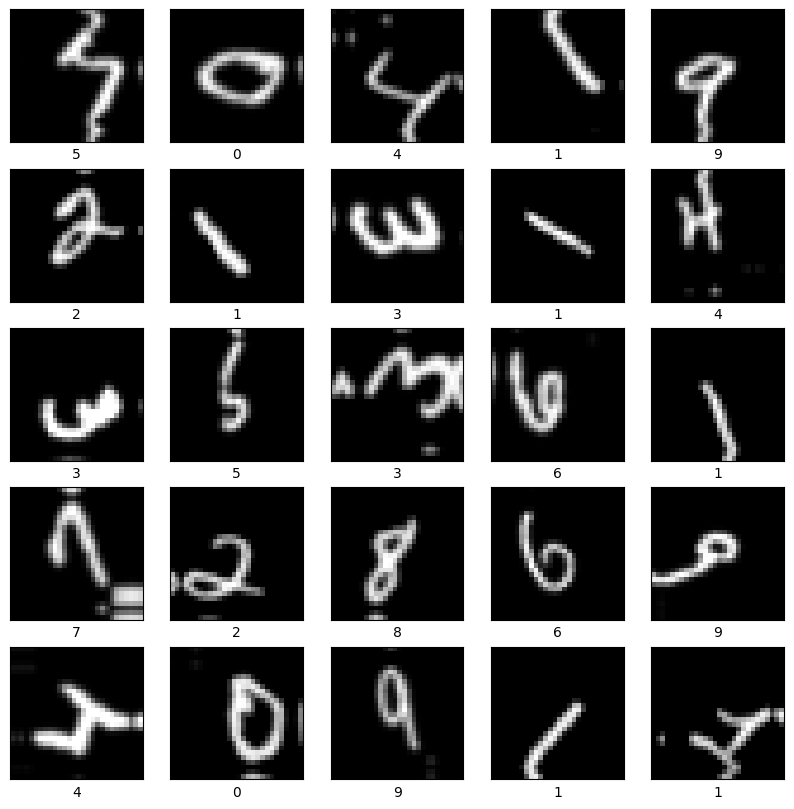

In [63]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.gray)
    plt.xlabel(y_train[i])
plt.show()

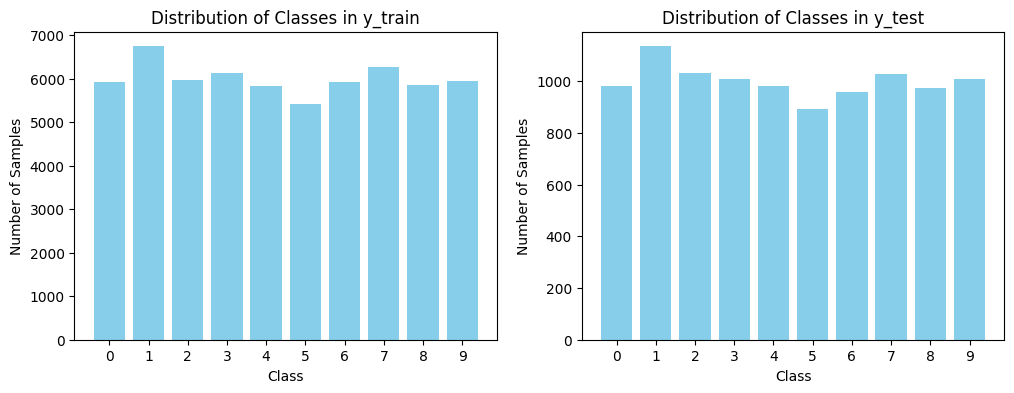

In [64]:
unique_classes_train, counts_train = np.unique(y_train, return_counts=True)
unique_classes_test, counts_test = np.unique(y_test, return_counts=True)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(unique_classes_train, counts_train, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in y_train')
plt.xticks(unique_classes_train)  

plt.subplot(1, 2, 2)
plt.bar(unique_classes_test, counts_test, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Classes in y_test')
plt.xticks(unique_classes_test)  
plt.show()

## 3 - CNN Modele

### Parameters

In [ ]:
# Parameters
epochs_cnn = 10
batch_size_cnn = 100
k_folds = 4
learning_rate_cnn = 0.001
metric_cnn = ["accuracy"]  #"SparseCategoricalAccuracy"
monitor_callback_cnn = "val_loss"
patience_callback_cnn = 3
mode_callback_cnn = None  # "max"

### Others functions

In [66]:
# To have the same modifications that the perturbations
data_augmentation = Sequential([
    RandomRotation(0.2),
    RandomTranslation(0.2, 0.2),
    RandomZoom(0.2),
    RandomBrightness((-0.2, 0.2), [0.0, 1.0])
])

### Modele

In [67]:
def create_cnn_model():
    cnn_model = Sequential([
        #data_augmentation,
        Conv2D(64, (3, 3), activation='relu', kernel_initializer="he_uniform", input_shape=(28, 28, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(32, (2, 2), activation='relu', kernel_initializer="he_uniform"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(32,  activation='relu', kernel_initializer="he_uniform"),
        Dropout(0.3),

        # Dense(32,  activation='relu'),
        # Dropout(0.3),
        
        Dense(10, activation='softmax')
        ])

    cnn_model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate_cnn),
                    loss='sparse_categorical_crossentropy',
                    metrics=metric_cnn
        )
    return cnn_model

In [ ]:
skf = StratifiedKFold(n_splits=k_folds, shuffle=True)
fold_results = []
best_cnn_model = None
best_accuracy = 0.0
best_cnn_history = None
best_histories = [(None, 0.0) for i in range (k_folds)]

# Cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_cnn, y_train)):
    print(f"\nFold {fold + 1}/{k_folds}")


    X_train_fold, X_val_fold = X_train_cnn[train_idx], X_train_cnn[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # New model for the current fold
    cnn_model = create_cnn_model()

    # Train the model
    history = cnn_model.fit(
        X_train_fold, y_train_fold,
        epochs=epochs_cnn,
        batch_size=batch_size_cnn,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[EarlyStopping(monitor=monitor_callback_cnn, patience=patience_callback_cnn, mode=mode_callback_cnn, restore_best_weights=True)],
        verbose=1
    )

    # Evaluate the model
    val_loss, val_accuracy = cnn_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation accuracy for fold {fold + 1}: {val_accuracy:.4f}")

    # Store the results
    fold_results.append(val_accuracy)

    if val_accuracy > best_histories[fold][1] :
        best_histories[fold] = (cnn_model, val_accuracy)

    # Kepp the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_cnn_model = cnn_model
        best_cnn_history = history

# Print the result
print("\nCross-validation results:")
for i, accuracy in enumerate(fold_results):
    print(f"Fold {i + 1}: Validation accuracy = {accuracy:.4f}")

print(f"\nBest validation accuracy: {best_accuracy:.4f}")

# Retourner le meilleur modèle
print("\nBest model summary:")
best_cnn_model.summary()


Fold 1/4


/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/keras/src/callbacks/early_stopping.py:77: UserWarning: EarlyStopping mode 'None' is unknown, fallback to auto mode.
  super().__init__(monitor, mode, min_delta=min_delta)
/home/hbreton/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  war

Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 119s 265ms/step - accuracy: 0.2504 - loss: 2.0322 - val_accuracy: 0.2055 - val_loss: 2.2891
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 124s 274ms/step - accuracy: 0.4388 - loss: 1.5640 - val_accuracy: 0.6542 - val_loss: 1.1059
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 126s 279ms/step - accuracy: 0.5385 - loss: 1.3100 - val_accuracy: 0.4027 - val_loss: 2.2000
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 124s 275ms/step - accuracy: 0.5979 - loss: 1.1596 - val_accuracy: 0.1950 - val_loss: 4.9726
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 124s 274ms/step - accuracy: 0.6435 - loss: 1.0490 - val_accuracy: 0.7851 - val_loss: 0.6811
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 126s 281ms/step - accuracy: 0.6658 - loss: 0.9803 - val_accuracy: 0.0975 - val_loss: 40.3659
Epoch 7/10
232/450 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - accuracy: 0.6794 - loss: 0.9393

### Results

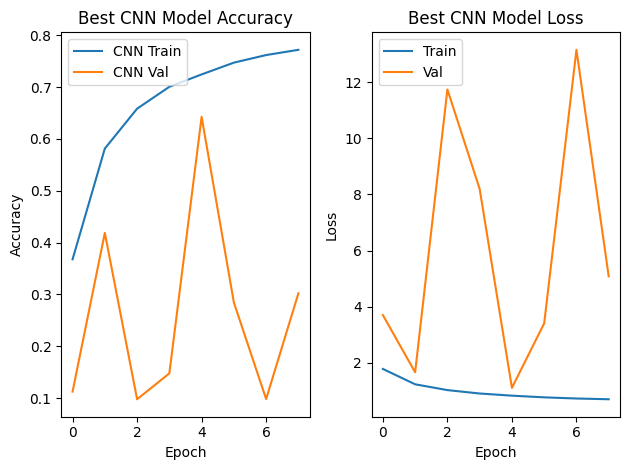

In [ ]:
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(best_cnn_history.history["accuracy"], label='CNN Train')
plt.plot(best_cnn_history.history['val_' + "accuracy"], label='CNN Val')
plt.title('Best CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(best_cnn_history.history['loss'], label='Train')
plt.plot(best_cnn_history.history['val_loss'], label='Val')
plt.title('Best CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Predict classes using the cnn model
y_pred_cnn = best_cnn_model.predict(X_test_cnn)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


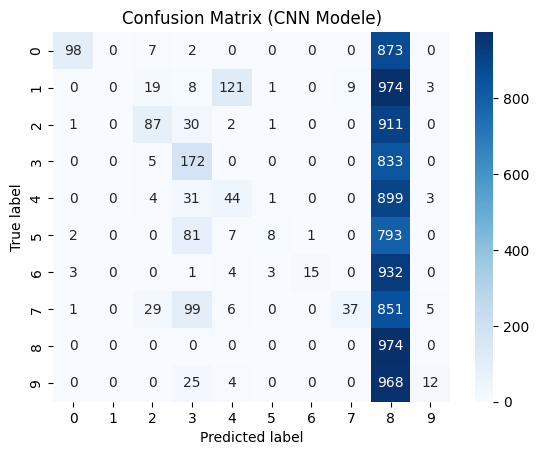

Class 0:
  Sensitivity (SEV): 0.1000
  Specificity (SPE): 0.9992
  Accuracy: 0.9111
  F1-score: 0.1806

Class 1:
  Sensitivity (SEV): 0.0000
  Specificity (SPE): 1.0000
  Accuracy: 0.8865
  F1-score: 0.0000

Class 2:
  Sensitivity (SEV): 0.0843
  Specificity (SPE): 0.9929
  Accuracy: 0.8991
  F1-score: 0.1471

Class 3:
  Sensitivity (SEV): 0.1703
  Specificity (SPE): 0.9692
  Accuracy: 0.8885
  F1-score: 0.2358

Class 4:
  Sensitivity (SEV): 0.0448
  Specificity (SPE): 0.9840
  Accuracy: 0.8918
  F1-score: 0.0752

Class 5:
  Sensitivity (SEV): 0.0090
  Specificity (SPE): 0.9993
  Accuracy: 0.9110
  F1-score: 0.0177

Class 6:
  Sensitivity (SEV): 0.0157
  Specificity (SPE): 0.9999
  Accuracy: 0.9056
  F1-score: 0.0308

Class 7:
  Sensitivity (SEV): 0.0360
  Specificity (SPE): 0.9990
  Accuracy: 0.9000
  F1-score: 0.0689

Class 8:
  Sensitivity (SEV): 1.0000
  Specificity (SPE): 0.1099
  Accuracy: 0.1966
  F1-score: 0.1952

Class 9:
  Sensitivity (SEV): 0.0119
  Specificity (SPE): 0.9988

In [ ]:
# Confusion matrix
matrix = confusion_matrix(y_test, y_pred_classes_cnn)  # Compare true labels (y_test) and predicted labels (y_pred_classes_dense)

# Plot confusion matrix
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (CNN Modele)')
plt.show()

# Calculate Sensitivity (SEV) and Specificity (SPE) for each class
for i in range(matrix.shape[0]):
    tp = matrix[i, i]
    fn = np.sum(matrix[i, :]) - tp
    fp = np.sum(matrix[:, i]) - tp
    tn = np.sum(matrix) - tp - fn - fp
    f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0  # F1-score
    sev = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity (Recall)
    spe = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
    accuracy = (tn + tp) / (tp + fn + tn + fp)
    print(f'Class {i}:')
    print(f'  Sensitivity (SEV): {sev:.4f}')
    print(f'  Specificity (SPE): {spe:.4f}')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  F1-score: {f1:.4f}\n')

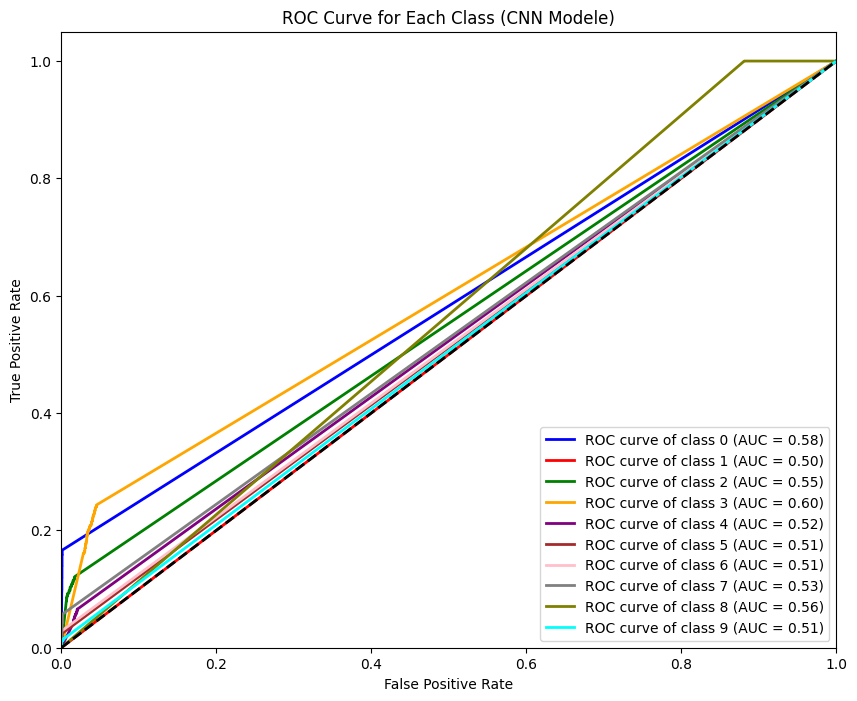

In [ ]:
# Binarize the output for ROC curve (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_cnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class (CNN Modele)')
plt.legend(loc="lower right")
plt.show()